### Mixed foraging and compartment model

broadly
- do equids as trial
    - range of equid body masses, fitness, prop grass

To do
- review g vs kg in allometric equations
- (done) track and output mean and std of body condition 
- identify problem with energy loss
- fix problem with energy loss



Problems
- central problem is starvation never occurs. Need to iron out metabolic rates


Notes
- might be able to speed up by not regenerating distributions 


##### Current State of Variables
1) foraging strategies - Justin's 
2) alpha               - allometric
3) beta                - allometric
4) gamma               - allometric
5) resource gain       - 16.7 kj/g as in pure carb/protein
6) mouth size          - allometric
7) gut size            - allometric, gut type
8) fat max             - allometric
9) velocity            - allometric
10) metabolic rates    - allometric

In [1]:
using Distributed
using RCall
@everywhere using SharedArrays
@everywhere using Distributions
@everywhere using LinearAlgebra

include("./resource_functions.jl") # functions for the resource landscape
include("./consumer_functions.jl") # functions for the consumer dynamics
include("./intake_model_functions.jl") # functions for the consumer dynamics

    

find_nearest_resource (generic function with 2 methods)

In [2]:
using Random
Random.seed!(42);

In [3]:
number_resources = 2;
target_values = [0.0, 0.25, 0.5, 0.75, 1.0]; 
strategy_id = repeat(collect(1:number_resources), inner=(length(target_values), 1));
target_weight = repeat(target_values, outer=(number_resources, 1));
strategy_info = Tuple([strategy_id, target_weight]);


In [4]:
configurations = 10;

t = 0;   #[s]
t_max = 100000; # 2629800s in a month

species_list = [1.0, 10.0, 100.0, 1000.0, 10000.0];
#species_list = [1000.0]
number_species = length(species_list);

#mouth = 0;
#mouth_max = 10;   #[g]

#gut = 11;
#gut_fill_max = 1000;  #[g]





#fat = 10;
#fat_max = 100000;   #[g]

#velocity = 1.0;   #[m/s]

at_food = false;
cropping = false;
chewing = false;

#alpha = [alpha_allo(mass, "graze"), alpha_allo(mass, "browse")#[1.0, 1.5]; # [g/s]
#beta = 1.0;         # [g/s]
#gamma = 0.01;        # [g/s]
#rates = [alpha, beta, gamma];

#basal = 0.001      #[kj/s]
#field = 0.01;     #[kj/s]

num_succ = 0;


# first pass RLB plant data suggested 0.1-0.3 kgC/m2yr
# experiment with monthly productivity as mean 8.3-25 g/m2month
resource_gain = [16.7, 16.7];


In [5]:
# grass, browse
# justify pure forest and pure grassland distrib
resource_scenarios = [
                     #[[0.1 0.1]; [0.15 0.15]],
                     [[0.2 24.0]; [0.25 30.0]],
                     [[4.0 20.0];  [6.0  24.0]],
                     [[8.0 16.0];  [10.0 20.0]],
                     [[12.0 12.0]; [16.0 16.0]],
                     [[16.0 8.0];  [20.0 12.0]],
                     [[20.0 4.0];  [24.0 6.0]],
                     [[24.0 0.1];  [30.0 0.15]]
    ];

number_scenarios = length(resource_scenarios);

In [6]:
# construct a vector of graze values for the figure legends
graze_vec = zeros(0)
for i in 1:number_scenarios
    append!(graze_vec, resource_scenarios[i,1][1])
end
graze_vec;

In [7]:
a,b,c,d = find_metabolism(100)

(1.1225003752534979e6, 0.10122143853426284, 0.2643004228394641, 2.2450007505069957e6)

In [8]:
a - c * 2629800

427443.1232702752

In [9]:
# collect config_data for testing
test_data = zeros(Float64, configurations, 6);

# scenarios, data, species
species_data = zeros(Float64, number_scenarios, 7, length(strategy_id), number_species)

# loop through body masses
for species in 1:number_species
    strat_data = zeros(Float64, length(strategy_id), 7); # init array for storing data by config
    alpha = [alpha_allo(species_list[species], "graze"), 
        alpha_allo(species_list[species], "browse")]
    beta = beta_allo(species_list[species], "lophs and flat")

    mrt = mean_retention_time(species_list[species], "colon")
    #rates = [alpha, beta, gamma]
    
    
    mouth_max = bite_size_allo(species_list[species], "graze"); # [g]
    gut_fill_max = gut_volume_g(species_list[species], "colon")
    velocity = find_velocity(species_list[species]);
    initial_energy_state, basal, field, fat_max = find_metabolism(species_list[species]);
    costs = [basal, field];
    
    
for scenario in 1:length(resource_scenarios)
    resource_stats = resource_scenarios[scenario]
    
    
    
# loop through strategies
for target in 1:length(strategy_id)
    
config_data = zeros(Float64, configurations, 6); # init array for storing data by config

# loop through configurations
for config = 1:configurations  # loop from 1:10

#target=1;
t=0;
num_succ = [0,0];
at_food = false;
cropping = false;
chewing = false;

mouth = 0;  #[g]
gut = 100;   #[g]
fat = initial_energy_state;   #[g]
        
chosen_resource = 0;

###
#1 while there is time left in the day
while t <= t_max && fat >= 0

    gamma = outflow_rate(gut, mrt)
    #rates = [alpha, beta, gamma]
    ### ###
    #2 if you're hungry
    #if gut <= gut_fill_max && fat <= fat_max  
        
        # if you're not at some food
        if at_food == false;
            # selects a resource to go after
            #chosen_resource, distance = forage(strategy_id, target_weight, target, 
                #resource_stats);
            #travel_time = distance/velocity; 
            chosen_resource, travel_time = travel(strategy_id, target_weight, 
                            target, resource_stats, velocity, t, t_max)            
                        
            # move to the food
            mouth, gut, fat = update_compartments(travel_time, mouth, gut,
                fat, [alpha, beta, gamma], costs, resource_gain; travelling=true)
            t += travel_time;
            at_food = true;
                    
                if fat <= 0
                    break
                end
                    
        end
        
        ### ### ###
        #3 if mouth isn't full and you're not chewing and you're at some food
        if mouth < mouth_max &&  chewing == false && at_food == true  # crop some food
            handling_time = 1/alpha[chosen_resource]        
            mouth, gut, fat = update_compartments((1/handling_time), 
                mouth, gut, fat, [alpha, beta, gamma], costs, resource_gain; cropping=true, resource=chosen_resource)
            
            num_succ[chosen_resource] += 1
            t += handling_time
            at_food = false;
                    
                    if fat <= 0
                    break
                end
                    
        end
        
        # if you're mouth is full but not chewing
        if mouth >= mouth_max && chewing == false 
                    
                mouth = mouth_max;
                chewing = true # start chewing
        end
        
        
        if chewing == true && mouth > beta # if you are currently chewing   
            mouth, gut, fat = update_compartments((1/beta), mouth, 
                gut, fat, [alpha, beta, gamma], costs, resource_gain; chewing=true)
            t += (1/beta);
                    
                if fat <= 0
                    break
                end
                    
        end
        if chewing == true && mouth <= beta
                chewing = false
            
            end #3 end of if mouth isn't full and you're not chewing
        ### ### ###
                        
        #end #2 end of if you're not hungry
        ### ###    
        
                    
        # add note on why this was necessary
        mouth, gut, fat = update_compartments(1, mouth, 
                gut, fat, [alpha, beta, gamma], costs, resource_gain)
        
        #if fat <= 0
         #           break
          #      end
                
        t += 1.0;
            
    end  #1 end bout (while t<tmax_bout )
    ###
    
        
    config_data[config,1] = t;
    config_data[config,2] = num_succ[1];
    config_data[config,3] = num_succ[2];
    config_data[config,4] = mouth;
    config_data[config,5] = gut;
    config_data[config,6] = fat;
    
    end
# end loop through body configs
    #strat_data[target, 1] = mean(config_data)
    strat_data[target,1] = mean(config_data[:,1])
    strat_data[target,2] = mean(config_data[:,2])
    strat_data[target,3] = mean(config_data[:,3])
    strat_data[target,4] = mean(config_data[:,4])
    strat_data[target,5] = mean(config_data[:,5])
    strat_data[target,6] = mean(config_data[:,6])
    strat_data[target,7] = std(config_data[:,6])

    species_data[scenario,1,target, species] = strat_data[target,1]
    species_data[scenario,2,target, species] = strat_data[target,2]
    species_data[scenario,3,target, species] = strat_data[target,3]
    species_data[scenario,4,target, species] = strat_data[target,4]
    species_data[scenario,5,target, species] = strat_data[target,5]
    species_data[scenario,6,target, species] = strat_data[target,6]
    species_data[scenario,7,target, species] = strat_data[target,7]

    test_data=config_data
            
    end # end loop through strategies
        
    
        
        
        end # end loop through resource scenarios

   
    

    end #loop through masses
# if [row, colum]

# time, graze, browse, mouth, gut, fat

In [10]:
# scenarios, data, strategies, species
# time, graze, browse, mouth, gut, fat
species_data[:,:,1,1];

In [11]:
plotting_data = zeros(Float64, number_scenarios, 7, number_species); 

for scene in 1:number_scenarios
    for datum in 1:7
        for species in 1:number_species
            
            plotting_data[scene,datum,species]=mean(species_data[scene,datum,:,species])
            
        end
    end
end
# scenarios, data, species
plotting_data;

In [12]:
# make plotting data into three matrices (fitness, graze, browse)

fitness_data = zeros(Float64, number_scenarios, number_species,); 
graze_data = zeros(Float64, number_scenarios, number_species,); 
browse_data = zeros(Float64, number_scenarios, number_species,); 
condition_mean_data = zeros(Float64, number_scenarios, number_species,); 
condition_std_data = zeros(Float64, number_scenarios, number_species,); 




for scene in 1:number_scenarios
    for species in 1:number_species
            
        fitness_data[scene, species]=plotting_data[scene, 1, species]
        graze_data[scene, species]=plotting_data[scene, 2, species]
        browse_data[scene, species]=plotting_data[scene, 3, species]
        condition_mean_data[scene, species] = plotting_data[scene, 6, species]
        condition_std_data[scene, species] = plotting_data[scene, 7, species]
    end
end

condition_mean_data;

In [19]:
condition_mean_data

7×5 Array{Float64,2}:
 9138.95  98099.7  1.11447e6  1.31368e7  1.61495e8
 9267.79  99172.6  1.11885e6  1.31518e7  1.61553e8
 9247.24  99285.3  1.11923e6  1.31513e7  1.6158e8 
 9239.31  99270.6  1.11869e6  1.31455e7  1.61591e8
 9236.62  99193.3  1.11767e6  1.31372e7  1.61594e8
 9240.94  98983.3  1.1157e6   1.31245e7  1.61583e8
 9022.13  97757.7  1.10974e6  1.3098e7   1.61538e8

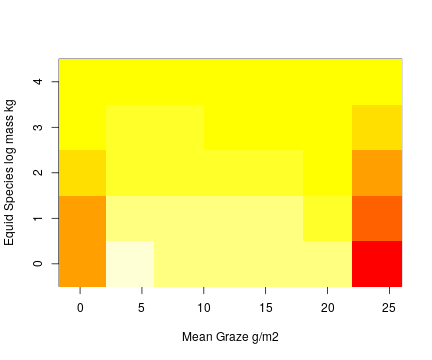

RObject{NilSxp}
NULL


In [13]:
condition_mean = condition_mean_data ./ sum(condition_mean_data,dims=1)

# Body condition mean
R"""

library(RColorBrewer)
pal<-brewer.pal(11,"Spectral")

image(y=log10($(species_list)),x=c($graze_vec) , z=$(condition_mean), 
        ylab="Equid Species log mass kg", xlab="Mean Graze g/m2")
"""

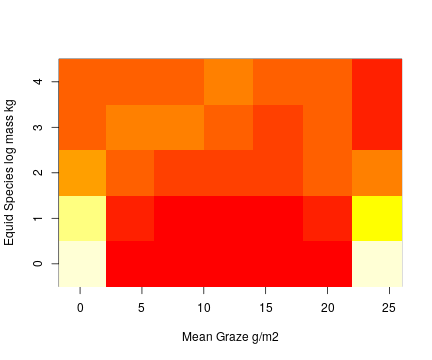

RObject{NilSxp}
NULL


In [14]:
condition_std_data = condition_std_data ./ sum(condition_std_data ,dims=1);


# body condition standard deviation
R"""

library(RColorBrewer)
pal<-brewer.pal(11,"Spectral")

image(y=log10($(species_list)),x=c($graze_vec) , z=$(condition_std_data), 
        ylab="Equid Species log mass kg", xlab="Mean Graze g/m2")
"""

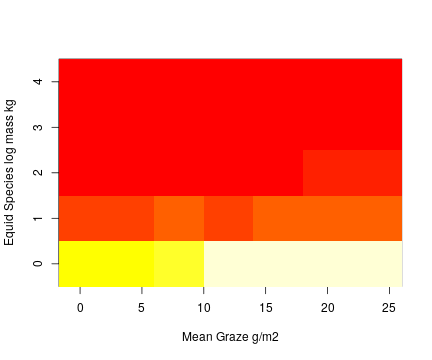

RObject{NilSxp}
NULL


In [15]:
# time survived
R"""

library(RColorBrewer)
pal<-brewer.pal(11,"Spectral")

image(y=log10($(species_list)),x=c($graze_vec) , z=$(fitness_data), ylab="Equid Species log mass kg", 
        xlab="Mean Graze g/m2")
"""

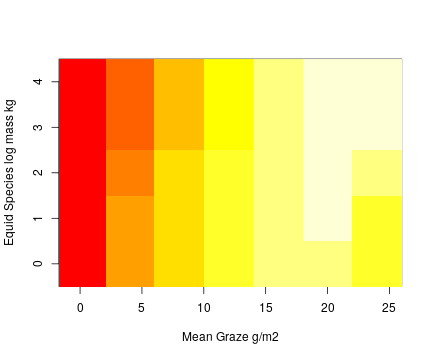

RObject{NilSxp}
NULL


In [16]:
graze = graze_data ./ sum(graze_data ,dims=1);

# graze in diet
R"""

library(RColorBrewer)
pal<-brewer.pal(11,"Spectral")

image(y=log10($(species_list)),x=c($graze_vec), z=$(graze), ylab="Equid Species log mass kg", 
        xlab="Mean Graze g/m2")
"""

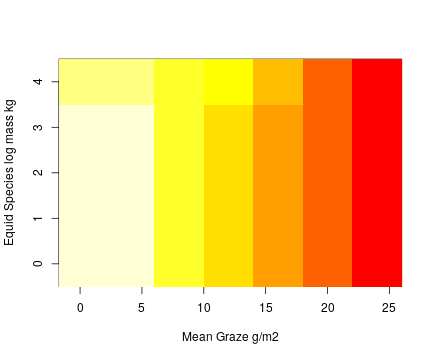

RObject{NilSxp}
NULL


In [17]:
browse = browse_data ./ sum(browse_data ,dims=1);

# browse in diet
#y=c(graze_vec)
R"""
library(RColorBrewer)
pal<-brewer.pal(11,"Spectral")
image(y=log10($(species_list)), x=c($graze_vec) , z=$(browse), ylab="Equid Species log mass kg", 
        xlab="Mean Graze g/m2")
"""